## LIBRARIES

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2 # Model
from tensorflow.keras import layers, models

In [ ]:
import tensorflow as tf
print(tf.__version__)

2.20.0


# K-FOLD CROSS VALIDATION
## TO ESTIMATE MODEL PERFORMANCE

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import models, layers

# --- PARAMETERS ---
K = 5 # Assuming K=5 folds
IMAGE_SIZE = (128, 128)
BATCH_SIZE = 64
EPOCHS = 15

# --- DATA GENERATORS ---
train_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    horizontal_flip=True
)
test_gen = ImageDataGenerator(rescale=1./255)

# --- AGGREGATION LISTS ---
# Initialize lists to store the test metrics from each fold
test_loss_scores = []
test_accuracy_scores = []

# --- K-FOLD LOOP IMPLEMENTATION ---
for fold in range(1, K + 1):
    print(f"\n====================== Starting Fold {fold}/{K} ======================")

    train_path = f"training_folds/fold_{fold}/train"
    test_path  = f"training_folds/fold_{fold}/test"

    # 1. Load Data for the current fold
    # NOTE: train_data is used here only to get num_classes for the model build
    train_data = train_gen.flow_from_directory(
        train_path,
        target_size=IMAGE_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical'
    )

    test_data = test_gen.flow_from_directory(
        test_path,
        target_size=IMAGE_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=False
    )
    
    # 2. BUILD A NEW, FRESH MODEL FOR EACH FOLD (Crucial for K-Fold)
    tf.keras.backend.clear_session() # Clear prior model graphs
    
    base_model = MobileNetV2(input_shape=(128, 128, 3), include_top=False, weights='imagenet')
    base_model.trainable = False

    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        # Use the number of classes determined by the data generator
        layers.Dense(train_data.num_classes, activation='softmax')
    ])

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # 3. TRAIN MODEL FOR THIS FOLD
    print(f"Training Model for Fold {fold}...")
    model.fit(
        train_data,
        epochs=EPOCHS,
        verbose=0 # Set to 1 for detailed output per epoch
    )
    
    # 4. EVALUATE AND STORE METRICS (The Aggregation Step)
    print(f"Evaluating Model for Fold {fold}...")
    # model.evaluate returns a list: [loss, accuracy]
    loss, accuracy = model.evaluate(test_data, verbose=0) 
    
    test_loss_scores.append(loss)
    test_accuracy_scores.append(accuracy)
    
    print(f"Fold {fold} - Test Loss: {loss:.4f}, Test Accuracy: {accuracy*100:.2f}%")


# --- FINAL AGGREGATION AND REPORTING ---
print("\n\n====================== K-FOLD CROSS-VALIDATION RESULTS ======================")

# Convert lists to numpy arrays for easy calculation
accuracies = np.array(test_accuracy_scores)

# Calculate the mean and standard deviation
mean_accuracy = np.mean(accuracies)
std_accuracy = np.std(accuracies)

print(f"\nIndividual Fold Accuracies: {[f'{a*100:.2f}%' for a in accuracies]}")
print(f"Overall Cross-Validation Accuracy: {mean_accuracy*100:.2f}%")
print(f"Standard Deviation of Accuracy: {std_accuracy*100:.2f}%")

print("\n--- Model is estimated to generalize with this performance. ---")


====================== Starting Fold 1/5 ======================
Found 600 images belonging to 3 classes.
Found 150 images belonging to 3 classes.

Training Model for Fold 1...
Evaluating Model for Fold 1...
Fold 1 - Test Loss: 0.1151, Test Accuracy: 94.67%

====================== Starting Fold 2/5 ======================
Found 600 images belonging to 3 classes.
Found 150 images belonging to 3 classes.
Training Model for Fold 2...
Evaluating Model for Fold 2...
Fold 2 - Test Loss: 0.2041, Test Accuracy: 95.33%

====================== Starting Fold 3/5 ======================
Found 600 images belonging to 3 classes.
Found 150 images belonging to 3 classes.
Training Model for Fold 3...
Evaluating Model for Fold 3...
Fold 3 - Test Loss: 0.1211, Test Accuracy: 95.33%

====================== Starting Fold 4/5 ======================
Found 600 images belonging to 3 classes.
Found 150 images belonging to 3 classes.
Training Model for Fold 4...
Evaluating Model for Fold 4...
Fold 4 - Test Loss: 0

# MODEL TRAINING

In [ ]:
# Parameters
IMAGE_SIZE = (128, 128)
BATCH_SIZE = 64
EPOCHS = 15 # epoch for train models

# Data Generators
train_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    horizontal_flip=True
)

test_gen = ImageDataGenerator(rescale=1./255)

for fold in range(1, K+1):

    train_path = f"dataset_kfold/fold_{fold}/train"
    test_path  = f"dataset_kfold/fold_{fold}/test"

    train_data = train_gen.flow_from_directory(
        train_path,
        target_size=IMAGE_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical'
    )

    test_data = test_gen.flow_from_directory(
        test_path,
        target_size=IMAGE_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=False
    )

    # Train model for this fold
    model.fit(
        train_data,
        validation_data=test_data,
        epochs=EPOCHS
)


# Build Model using Transfer Learning
base_model = MobileNetV2(input_shape=(128, 128, 3), include_top=False, weights='imagenet')
base_model.trainable = False  # Freeze the base model layers initially

# Define the full model matrix form
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(train_data.num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(train_data, validation_data=test_data, epochs=EPOCHS)

## MODEL EVALUATION ##

6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 350ms/step


<Figure size 800x600 with 0 Axes>

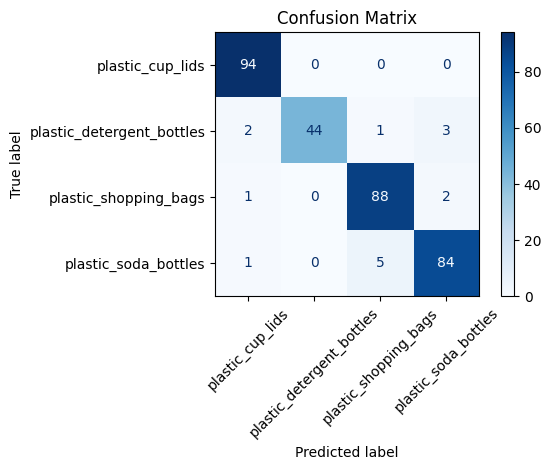

Classification Report:

                           precision    recall  f1-score   support

         plastic_cup_lids       0.96      1.00      0.98        94
plastic_detergent_bottles       1.00      0.88      0.94        50
    plastic_shopping_bags       0.94      0.97      0.95        91
     plastic_soda_bottles       0.94      0.93      0.94        90

                 accuracy                           0.95       325
                macro avg       0.96      0.95      0.95       325
             weighted avg       0.95      0.95      0.95       325



In [ ]:
# Predict the classes on test data
pred_probs = model.predict(test_data)
pred_labels = np.argmax(pred_probs, axis=1)

# Get true labels and class names
true_labels = test_data.classes
class_names = list(test_data.class_indices.keys())

# Generate confusion matrix
cm = confusion_matrix(true_labels, pred_labels)

# Display confusion matrix
plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("Confusion Matrix")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

import sklearn 

# Classification report
report = sklearn.metrics.classification_report(true_labels, pred_labels, target_names=class_names)
print("Classification Report:\n")
print(report)

# MODEL TESTING